# notebook for meeting 09-05
Showing progress with new likelihood function, and fixing the `obs_noise' function issue

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_lh2 import WMSE
from pitchfuncs_lh2 import InversePCA
from pitchfuncs_lh2 import emulator
from pitchfuncs_lh2 import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
from scipy import stats
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import json
import matplotlib.pyplot as plt

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


2024-05-09 15:24:01.473376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 15:24:01.473408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 15:24:01.474505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 15:24:01.479881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 15:24:01.978163: W tensorflow/compiler/tf2

## 1) import hare and pitchfork

In [2]:
hare = pd.read_json("solar_hare2.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]
hare_true = hare[outputs]

hare

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std
4098711,1,0.013508,0.24,1.9,4.605898,0.993668,0.904566,5650.91516,-0.0558,684.334509,...,0.727786,0.729035,0.730063,0.729626,0.730431,0.730403,0.729293,0.727165,0.724994,-0.345785


In [3]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-05-09 15:24:04.408757: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-09 15:24:04.408777: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-05-09 15:24:04.408782: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-05-09 15:24:04.408873: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-05-09 15:24:04.408891: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2024-05-09 15:24:04.408895: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.171.4


## 2) define priors
this uses the min and max trained ranges stored in the emulator pickle dict

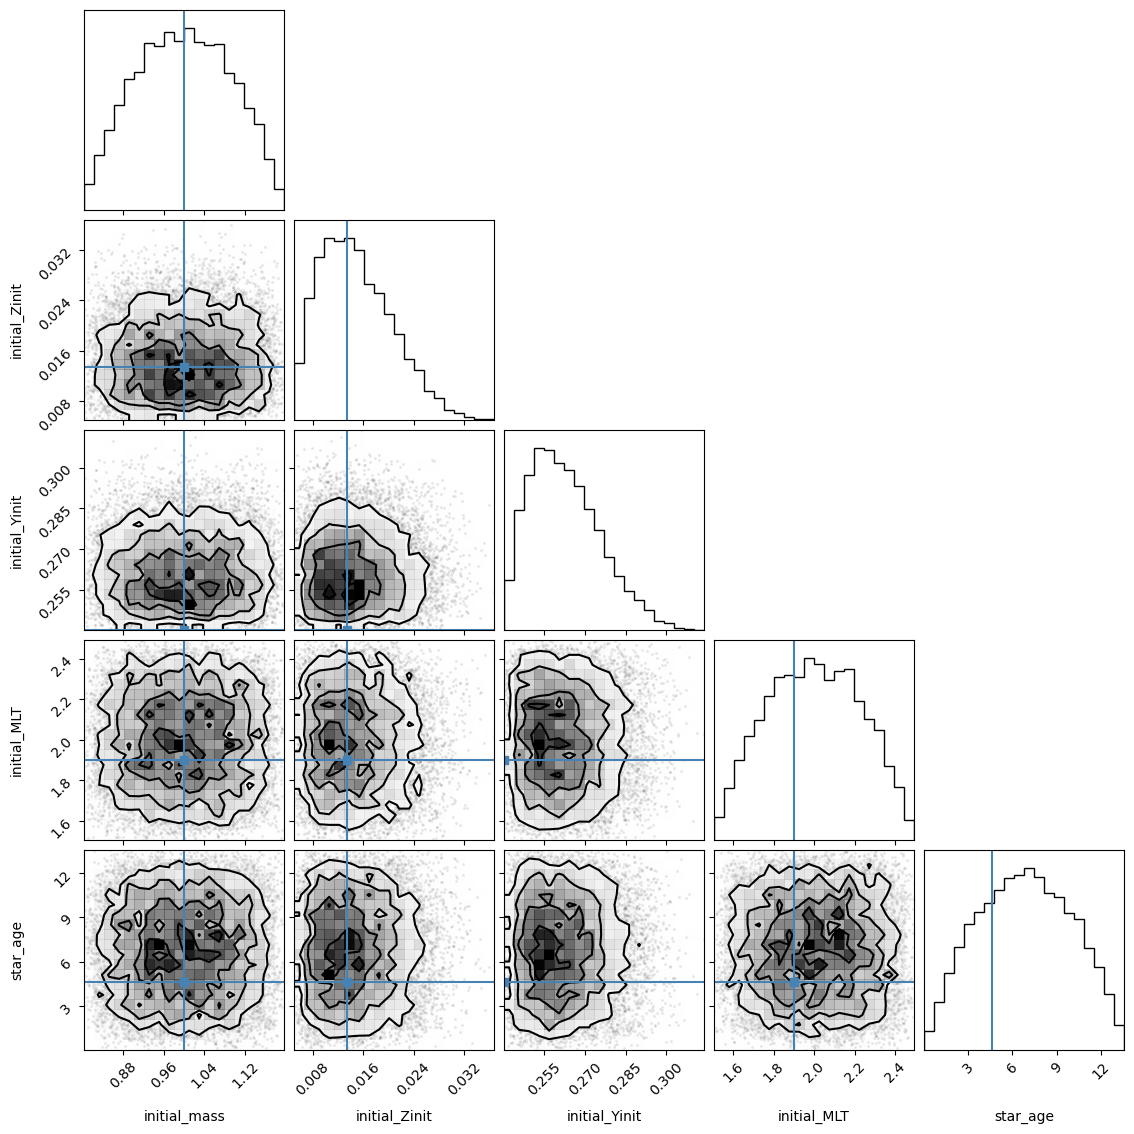

In [52]:
def grid_uniform_prior(pitchfork_ranges, header):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.uniform(loc=grid_min, scale=max(list(pitchfork_ranges["log_"+header].values()))-grid_min)

def grid_beta_prior(pitchfork_ranges, header,a=1,b=1):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.beta(loc=grid_min, scale=grid_max-grid_min, a=a, b=b)

def custom_uniform_prior(prior_min, prior_max):
    return scipy.stats.uniform(loc=prior_min, scale=prior_max-prior_min)

def custom_beta_prior(prior_min, prior_max, a=1, b=1):
    return scipy.stats.beta(loc=prior_min, scale=prior_max-prior_min, a=a, b=b)

mass_prior = custom_beta_prior(0.8, 1.2, a=2, b=2)

Zinit_prior = custom_beta_prior(0.005, 0.04, a=2, b=5)

Yinit_prior = custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = custom_beta_prior(1.5, 2.5, a=2, b=2)

age_prior = custom_beta_prior(0, 13.7, a=2, b=2)

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});

## 2) define uncertainties
this time we're taking emulation error seriously, define the observational uncertainty as before:

In [53]:
teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.1 #\muHz

obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc + (0.1*np.abs(23-i)) for i in range(6,41)])
obs_unc

array([7.0e+01, 4.0e-02, 1.0e-01, 1.8e+00, 1.7e+00, 1.6e+00, 1.5e+00,
       1.4e+00, 1.3e+00, 1.2e+00, 1.1e+00, 1.0e+00, 9.0e-01, 8.0e-01,
       7.0e-01, 6.0e-01, 5.0e-01, 4.0e-01, 3.0e-01, 2.0e-01, 1.0e-01,
       2.0e-01, 3.0e-01, 4.0e-01, 5.0e-01, 6.0e-01, 7.0e-01, 8.0e-01,
       9.0e-01, 1.0e+00, 1.1e+00, 1.2e+00, 1.3e+00, 1.4e+00, 1.5e+00,
       1.6e+00, 1.7e+00, 1.8e+00])

and now we load in the MAD of the emulator residuals as our emulation error on each parameter:

In [54]:
with open('emulator_unc.json') as json_file:
    emulator_unc_dict = json.load(json_file)

emulator_unc_dict['calc_effective_T'] = emulator_unc_dict.pop('effective_T')

emulator_unc = np.array([emulator_unc_dict[output]['std'] for output in outputs])
emulator_unc

array([5.80839930e+00, 1.30914531e-02, 1.01035214e-03, 3.09915241e-01,
       3.57661163e-01, 3.70136427e-01, 3.27691218e-01, 3.60723443e-01,
       3.35454316e-01, 3.51762936e-01, 3.50369036e-01, 3.76497195e-01,
       3.71989755e-01, 3.90479993e-01, 3.96656372e-01, 4.16603633e-01,
       4.32140612e-01, 4.35814313e-01, 4.66715118e-01, 4.93645626e-01,
       5.06698258e-01, 5.20393302e-01, 5.51736433e-01, 5.89510639e-01,
       5.82267557e-01, 6.40203865e-01, 6.50772528e-01, 6.70589752e-01,
       7.39056833e-01, 7.24054120e-01, 8.18775124e-01, 8.37316493e-01,
       8.53821582e-01, 9.61320133e-01, 8.88923787e-01, 9.91031773e-01,
       9.77581266e-01, 1.03337868e+00])

now we add these in quadrature to define our uncertainty that we use in the likelihood function:

In [55]:
unc = np.sqrt(obs_unc**2 + emulator_unc**2)
unc

array([7.02405688e+01, 4.20878384e-02, 1.00005104e-01, 1.82648500e+00,
       1.73721660e+00, 1.64225484e+00, 1.53537667e+00, 1.44572522e+00,
       1.34258318e+00, 1.25049477e+00, 1.15445158e+00, 1.06852709e+00,
       9.73846178e-01, 8.90210438e-01, 8.04572108e-01, 7.30450948e-01,
       6.60867240e-01, 5.91552293e-01, 5.54817989e-01, 5.32621821e-01,
       5.16471805e-01, 5.57502636e-01, 6.28023162e-01, 7.12406340e-01,
       7.67486487e-01, 8.77417226e-01, 9.55774494e-01, 1.04388247e+00,
       1.16456215e+00, 1.23460697e+00, 1.37127412e+00, 1.46324943e+00,
       1.55531710e+00, 1.69827454e+00, 1.74361277e+00, 1.88205844e+00,
       1.96103675e+00, 2.07554125e+00])

In [56]:
emulator_errors = pd.read_json('emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]
emulator_errors

,calc_effective_T,luminosity,star_feh,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,...,nu_0_31,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40
0,1.923269,-0.000165,-0.000484,0.144269,-0.462667,-0.250838,-0.798832,-0.156309,-0.339588,-0.868754,...,0.281421,0.419974,-0.096299,-0.695389,-0.367608,0.807108,1.625223,-2.934542,-2.155523,-1.758358
1,0.620388,-0.000271,-0.000464,-0.008636,-0.700756,-0.446926,-0.914589,-0.223743,-0.341258,-0.884319,...,0.097307,0.122588,-0.421236,-0.952874,-0.349897,0.804834,0.307938,-2.745218,-2.392087,-2.874111
2,0.433352,-0.000274,-0.000472,-0.073690,-0.776345,-0.519323,-0.989458,-0.298677,-0.398918,-0.949791,...,-0.145570,-0.150444,-0.704151,-1.223538,-0.582535,0.562711,-0.357406,-2.940105,-2.653332,-3.269268
3,0.360255,-0.000209,-0.000500,-0.152007,-0.849753,-0.565866,-1.035576,-0.329247,-0.337766,-0.882360,...,-0.325218,-0.412468,-0.979045,-1.412269,-0.624331,0.520714,-3.731763,-2.709889,-2.613945,-3.668847
4,0.588040,-0.000143,-0.000466,-0.122140,-0.802406,-0.505233,-0.973897,-0.253959,-0.213854,-0.747722,...,-0.129025,-0.241967,-0.794085,-1.186079,-0.342994,0.804759,-3.320295,-2.284215,-2.256346,-3.470091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122429,-7.356710,-0.009938,0.000629,0.152768,0.634809,0.320857,0.334960,0.572175,0.214805,0.393452,...,1.901456,2.517938,2.459341,2.169123,2.231622,2.383012,2.318748,2.352560,2.466695,2.566058
122430,4.106118,-0.038118,0.000500,-0.470416,0.470893,0.329083,-0.048767,0.094231,0.018933,-0.524172,...,-0.394664,-0.482586,-0.706038,-0.618565,-0.370062,-0.489049,-0.825498,-0.893396,-0.690679,-0.250742
122431,6.919575,-0.009889,-0.000299,-0.300936,0.543902,-0.077994,-0.225545,0.231112,0.021014,-0.147791,...,0.480300,0.202407,0.021159,0.278962,0.412166,0.253865,0.121367,0.095261,0.160782,0.410327
122432,3.364943,0.022790,0.000521,0.260287,-0.238324,0.048139,-0.040404,-0.039845,-0.179641,0.171434,...,0.404192,0.775037,0.855292,0.529170,0.375255,0.460825,0.689848,0.719678,0.601190,0.470765


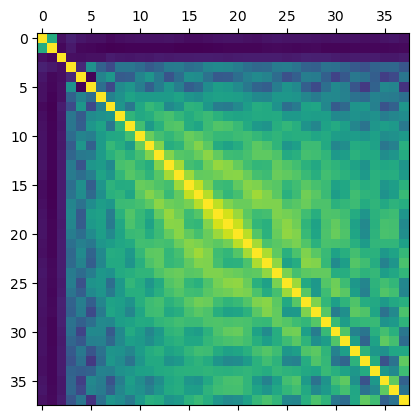

In [57]:
corr = np.corrcoef(emulator_errors.to_numpy().T)
plt.matshow(corr)

In [58]:
emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = obs_unc *(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

sigma_det = np.linalg.det(sigma)

## 3) define observed values
here's where I'll add simulated random observational noise to our observed values, deviating them slightly away from the "true" values:

In [59]:
def obs_noise(true, unc, seed=42):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs

hare_obs = obs_noise(hare_true.values[0],obs_unc)
hare_obs

array([ 5.73453257e+03,  9.11926141e-01, -1.14662366e-01,  9.81548403e+02,
        1.12785677e+03,  1.27228478e+03,  1.41830282e+03,  1.56229187e+03,
        1.70062771e+03,  1.83598174e+03,  1.97171446e+03,  2.10907914e+03,
        2.24538830e+03,  2.38104739e+03,  2.51711793e+03,  2.65268949e+03,
        2.78808954e+03,  2.92490512e+03,  3.06065121e+03,  3.19833669e+03,
        3.33575360e+03,  3.47324008e+03,  3.61178851e+03,  3.75060387e+03,
        3.88863090e+03,  4.02780934e+03,  4.16646902e+03,  4.30474827e+03,
        4.44487326e+03,  4.58277725e+03,  4.71923204e+03,  4.85924204e+03,
        4.98973633e+03,  5.12344081e+03,  5.25450172e+03,  5.38102790e+03,
        5.50811858e+03,  5.63426324e+03])

let's just print the true values to check these simulated observed values aren't ridiculous:

In [60]:
hare_true.values[0]

array([ 5.64697610e+03,  9.04566185e-01, -5.57996554e-02,  9.80082028e+02,
        1.12662696e+03,  1.27373361e+03,  1.41836579e+03,  1.56047718e+03,
        1.69956445e+03,  1.83591611e+03,  1.97267320e+03,  2.10940079e+03,
        2.24570981e+03,  2.38130085e+03,  2.51600184e+03,  2.65159776e+03,
        2.78789832e+03,  2.92446662e+03,  3.06147326e+03,  3.19835874e+03,
        3.33572663e+03,  3.47344367e+03,  3.61147901e+03,  3.74999080e+03,
        3.88844653e+03,  4.02723525e+03,  4.16609885e+03,  4.30482919e+03,
        4.44369914e+03,  4.58220684e+03,  4.72038373e+03,  4.85711724e+03,
        4.98945777e+03,  5.12366579e+03,  5.25505992e+03,  5.38316598e+03,
        5.50836512e+03,  5.63346647e+03])

## 4) show log-likelihood
now we've defined our "observed" values $\textbf{y}$ and their associated uncertainties $\sigma_{y,\textrm{obs}}$ and $\sigma_{y,\textrm{NN}}$, we have what we need to define our log-likelihood function that we'll use during nested sampling:
$$\mathcal{L}(\textbf{y}|\theta) = \sum_{i}\log\mathcal{N}(y_{i}, \sqrt{\sigma_{y_{i},\textrm{obs}}^2 + \sigma_{y_{i},\textrm{NN}}^2}),$$
Now we're properly incorporating neural network uncertainty into our likelihood equation!

## 5) run dynesty

In [ ]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=hare_true.values[0], observed_unc=unc, sigma_det=sigma_det, sigma_inv=sigma_inv, pitchfork=pitchfork, logl_scale=1)
posterior = sampler(nlive=500,sample='rwalk', bound='multi')
toc = time.time()

figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(posterior, fig=figure, color='red',hist_kwargs={'density':True}, smooth=True);

These all look very good! However, I'm using a fairly unrestrictive $\sigma_{obs}$ for $\nu$ of $\sim0.5\mu \textrm{Hz}$. What if we make this more conservative (and realistic)?

# 7) Adding draws random uncertainty
Here I'll run 5 sampling runs by using the same hare with the same truth values, but applying 5 different draws of random noise from our defined observational uncertainty ranges:

In [16]:
def obs_noise(true, unc, seed=42):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs

seeds = [1, 2, 3, 4, 5]

posteriors_dict_noise = {}
for seed in seeds:
    print(f'current seed: {seed}', end='\r')
    sampler = ns(priors=priors, observed_vals=obs_noise(hare_true.values[0],obs_unc, seed=seed), observed_unc=unc, sigma=sigma, sigma_inv=sigma_inv, pitchfork=pitchfork, logl_scale=1)
    posterior_i = sampler(nlive=250,sample='rwalk', bound='multi')
    posteriors_dict_noise[f'posterior_{seed}'] = posterior_i

iter: 4741 | +250 | bound: 103 | nc: 1 | ncall: 105132 | eff(%):  4.759 | loglstar:   -inf < -55.275 <    inf | logz: -72.831 +/-  5.187 | dlogz:  0.001 >  0.259                                     

iter: 4830 | +250 | bound: 105 | nc: 1 | ncall: 107811 | eff(%):  4.723 | loglstar:   -inf < -62.826 <    inf | logz: -80.741 +/- 10.407 | dlogz:  0.001 >  0.259                                     

iter: 4990 | +250 | bound: 108 | nc: 1 | ncall: 111136 | eff(%):  4.726 | loglstar:   -inf < -59.647 <    inf | logz: -78.202 +/-  0.574 | dlogz:  0.001 >  0.259                                     

iter: 4753 | +250 | bound: 103 | nc: 1 | ncall: 106023 | eff(%):  4.730 | loglstar:   -inf < -44.792 <    inf | logz: -62.391 +/-    nan | dlogz:  0.001 >  0.259                                     

iter: 4694 | +250 | bound: 100 | nc: 1 | ncall: 103701 | eff(%):  4.779 | loglstar:   -inf < -50.167 <    inf | logz: -67.522 +/-  0.496 | dlogz:  0.001 >  0.259                                     

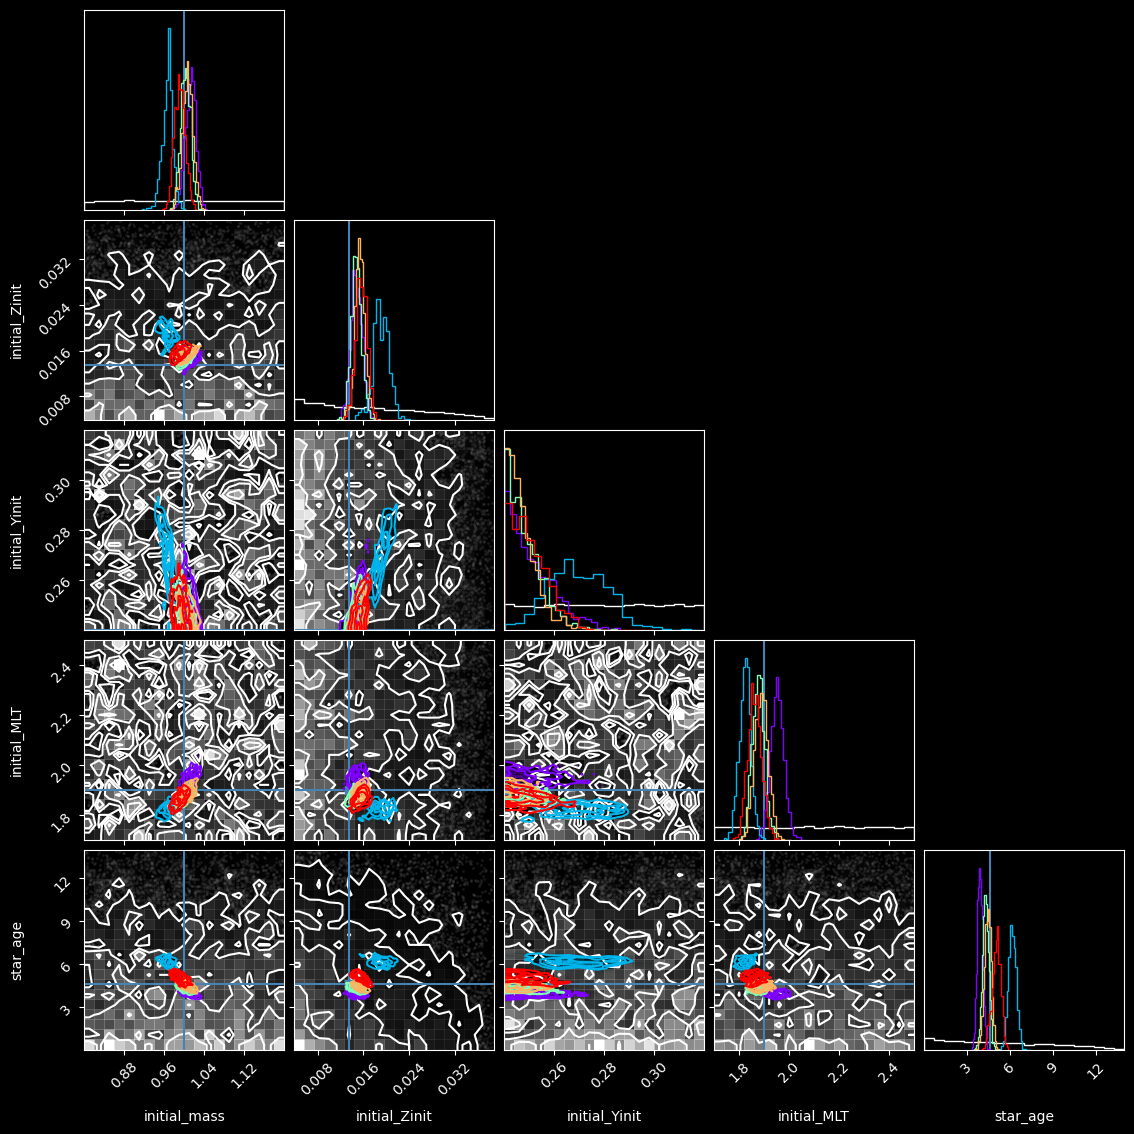

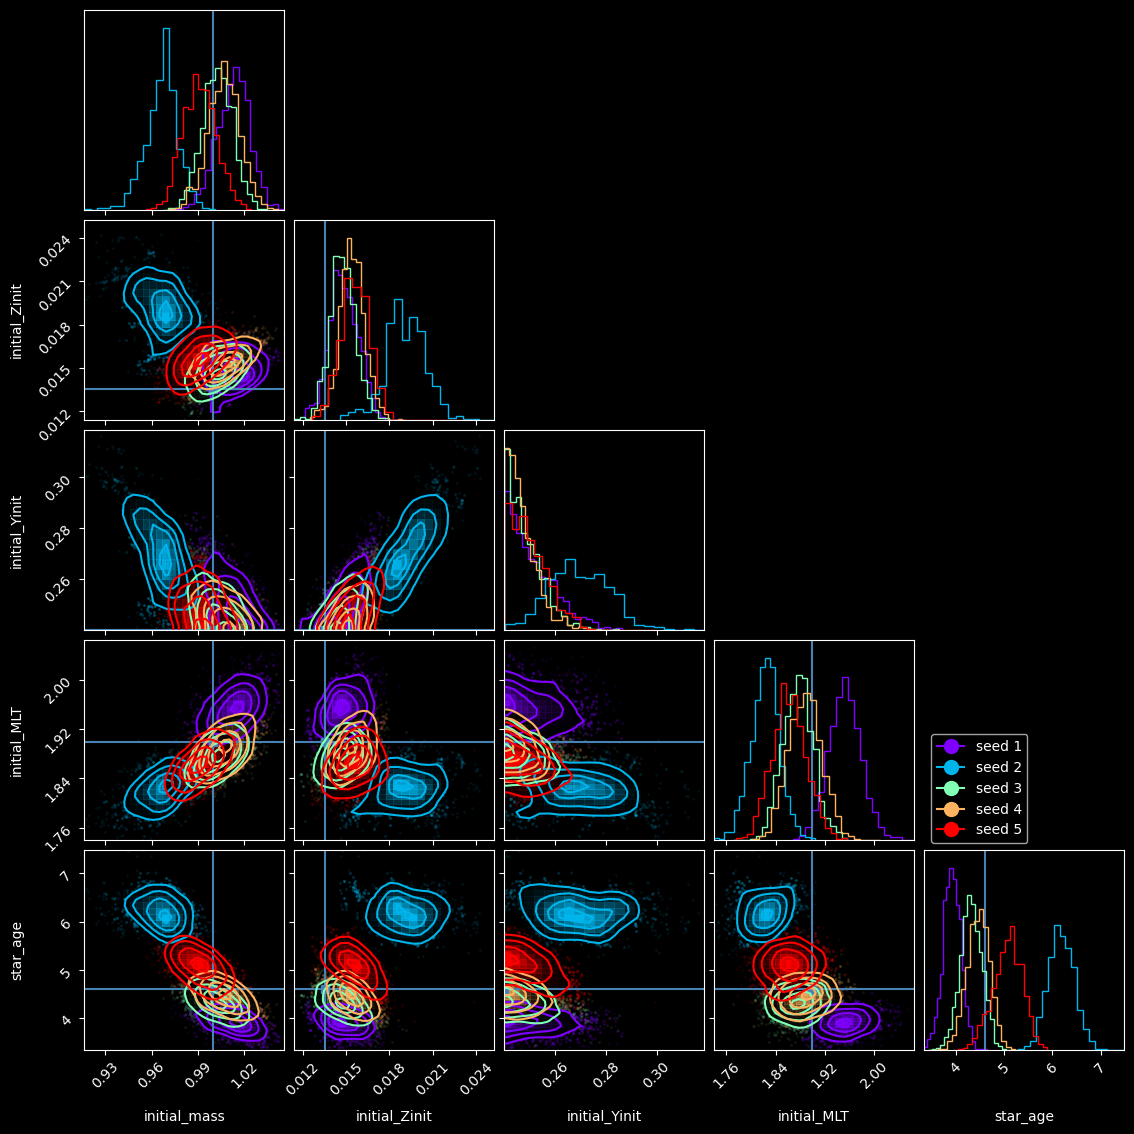

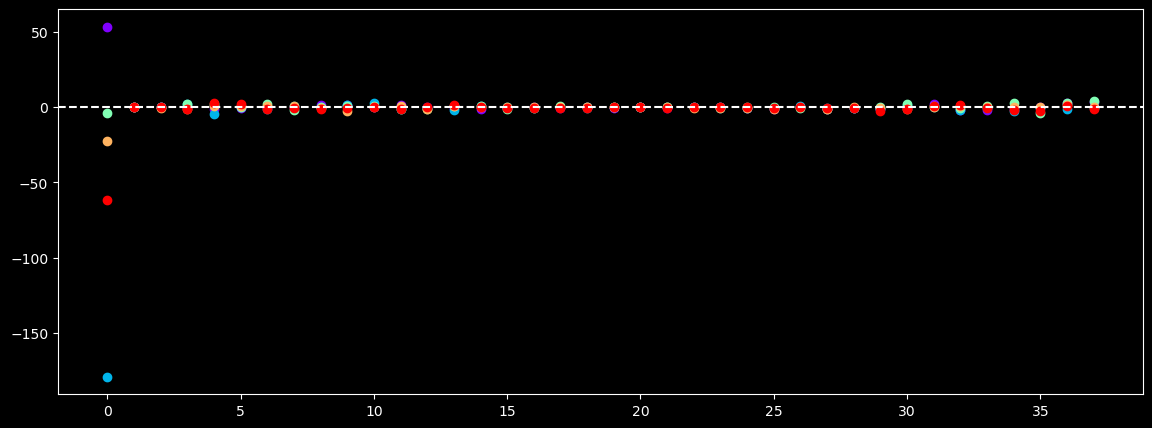

In [17]:
from matplotlib.lines import Line2D
plt.style.use('dark_background')
color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0],hist_kwargs={'density':True});
for seed in seeds:
    c = next(color)
    corner.corner(posteriors_dict_noise[f'posterior_{seed}'], fig=figure, color=c,hist_kwargs={'density':True});

color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
legend_labels = []
i=0
for seed in seeds:
    c = next(color)
    if i == 0:
        legend_labels = legend_labels + [Line2D([0], [0], marker='o', color=c, markerfacecolor=c, markersize=10, label=f'seed {seed}')]
        figure = corner.corner(posteriors_dict_noise[f'posterior_{seed}'], labels = inputs, truths = hare_inps.values[0], color=c,hist_kwargs={'density':True},smooth=True);
        i+=1
    else:
        legend_labels = legend_labels + [Line2D([0], [0], marker='o', color=c, markerfacecolor=c, markersize=10, label=f'seed {seed}')]
        corner.corner(posteriors_dict_noise[f'posterior_{seed}'], fig=figure, color=c,hist_kwargs={'density':True},smooth=True);

plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)

def obs_noise(true, unc, seed=42):
    set_seed = np.random.seed(seed=seed)
    random_states = np.random.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=random_states[idx])
        idx+=1

    return noisy_obs


color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
fig, ax = plt.subplots(figsize=(14,5))
for seed in seeds:
    c = next(color)
    observed_vals=obs_noise(hare_true.values[0],obs_unc, seed=seed)
    plt.scatter(np.arange(0, len(observed_vals),1), observed_vals-hare_true.values[0], color=c)

plt.axhline(0, linestyle='--')

In [18]:
def obs_noise(true, unc, seed=42):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs

seeds = [6, 7, 8, 9, 10]

posteriors_dict_noise = {}
for seed in seeds:
    print(f'current seed: {seed}', end='\r')
    sampler = ns(priors=priors, observed_vals=obs_noise(hare_true.values[0],obs_unc, seed=seed), observed_unc=unc, sigma=sigma, sigma_inv=sigma_inv, pitchfork=pitchfork, logl_scale=1)
    posterior_i = sampler(nlive=250,sample='rwalk', bound='multi')
    posteriors_dict_noise[f'posterior_{seed}'] = posterior_i

iter: 4712 | +250 | bound: 102 | nc: 1 | ncall: 104627 | eff(%):  4.754 | loglstar:   -inf < -44.715 <    inf | logz: -62.165 +/-    nan | dlogz:  0.001 >  0.259                                     

iter: 4779 | +250 | bound: 103 | nc: 1 | ncall: 105990 | eff(%):  4.756 | loglstar:   -inf < -49.831 <    inf | logz: -67.520 +/-  3.640 | dlogz:  0.001 >  0.259                                     

iter: 4936 | +250 | bound: 108 | nc: 1 | ncall: 110322 | eff(%):  4.711 | loglstar:   -inf < -45.849 <    inf | logz: -64.179 +/-    nan | dlogz:  0.001 >  0.259                                     

iter: 4935 | +250 | bound: 108 | nc: 1 | ncall: 110113 | eff(%):  4.720 | loglstar:   -inf < -50.027 <    inf | logz: -68.359 +/-  0.157 | dlogz:  0.001 >  0.259                                     

iter: 4835 | +250 | bound: 106 | nc: 1 | ncall: 107838 | eff(%):  4.726 | loglstar:   -inf < -49.171 <    inf | logz: -67.095 +/-    nan | dlogz:  0.001 >  0.259                                     

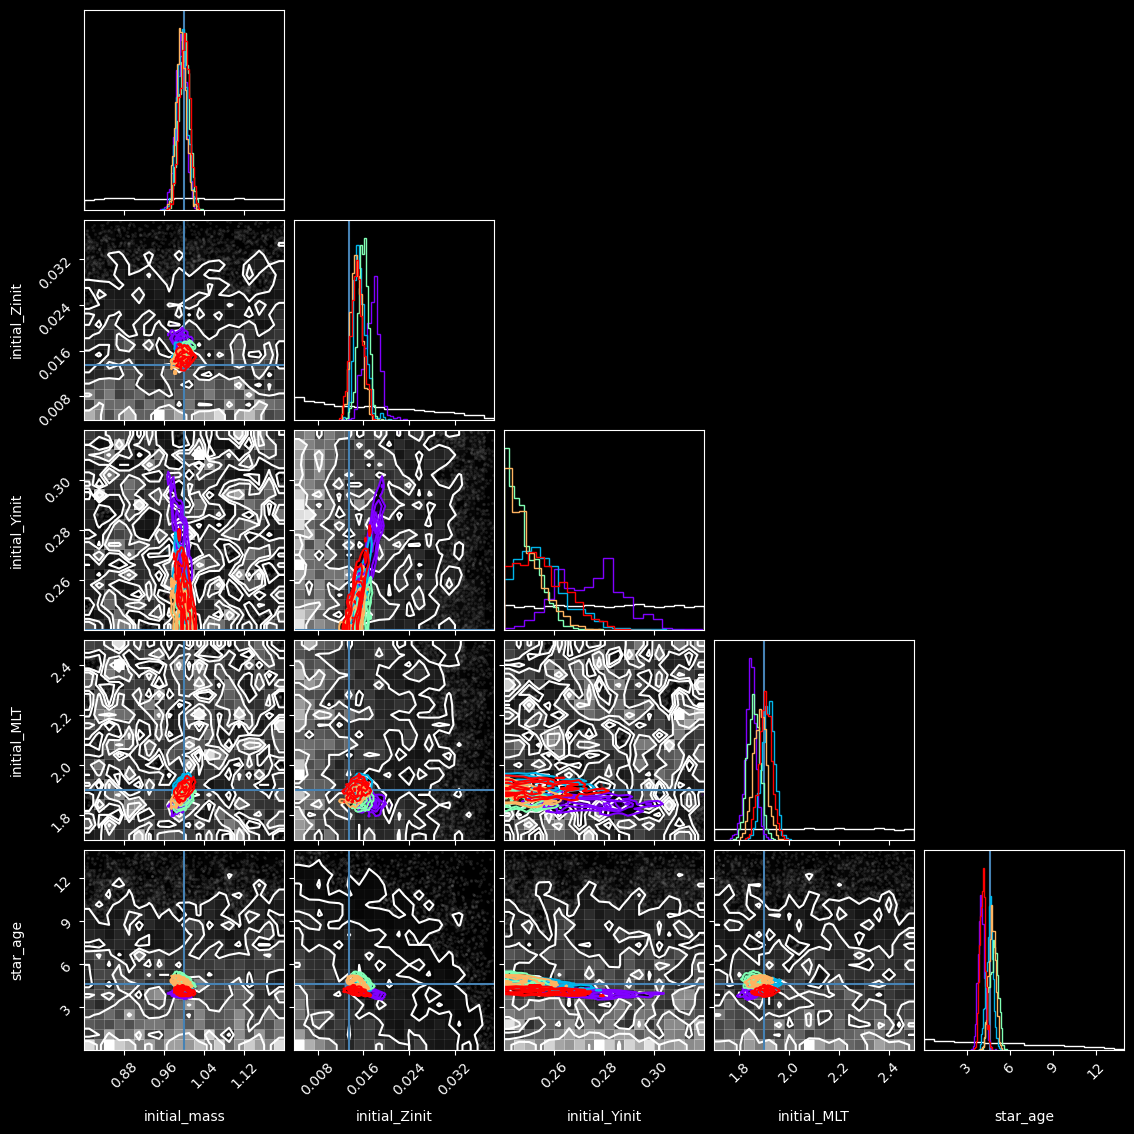

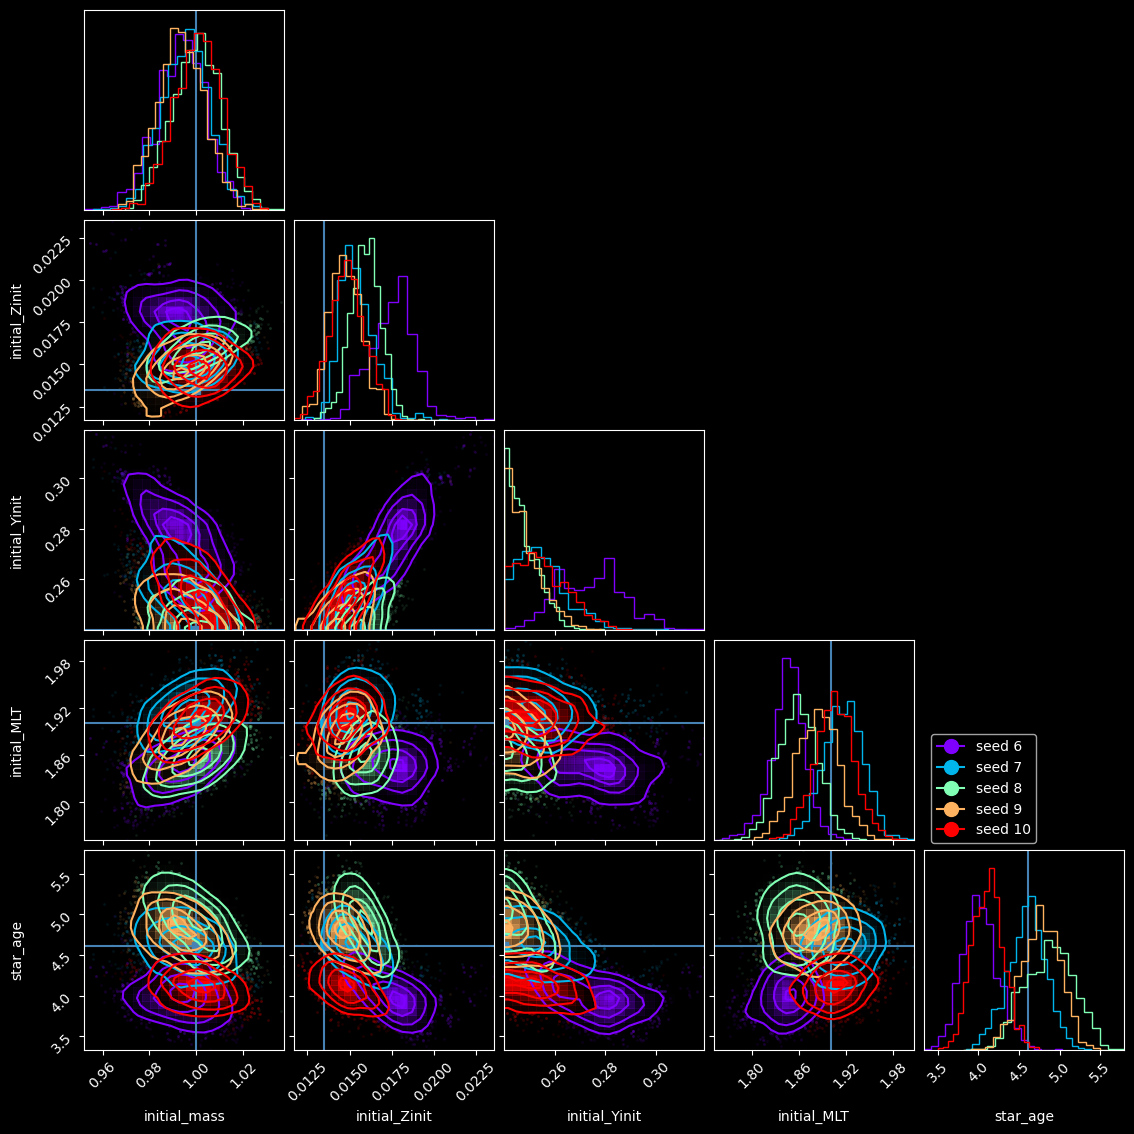

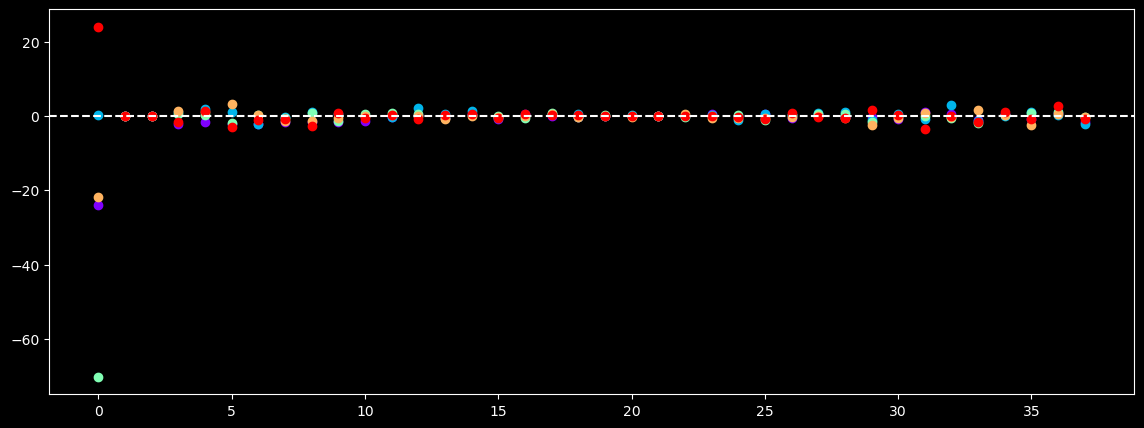

In [27]:
from matplotlib.lines import Line2D
plt.style.use('dark_background')
color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0],hist_kwargs={'density':True});
for seed in seeds:
    c = next(color)
    corner.corner(posteriors_dict_noise[f'posterior_{seed}'], fig=figure, color=c,hist_kwargs={'density':True});

color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
legend_labels = []
i=0
for seed in seeds:
    c = next(color)
    if i == 0:
        legend_labels = legend_labels + [Line2D([0], [0], marker='o', color=c, markerfacecolor=c, markersize=10, label=f'seed {seed}')]
        figure = corner.corner(posteriors_dict_noise[f'posterior_{seed}'], labels = inputs, truths = hare_inps.values[0], color=c,hist_kwargs={'density':True},smooth=True);
        i+=1
    else:
        legend_labels = legend_labels + [Line2D([0], [0], marker='o', color=c, markerfacecolor=c, markersize=10, label=f'seed {seed}')]
        corner.corner(posteriors_dict_noise[f'posterior_{seed}'], fig=figure, color=c,hist_kwargs={'density':True},smooth=True);

plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)

def obs_noise(true, unc, seed=42):
    set_seed = np.random.seed(seed=seed)
    random_states = np.random.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=random_states[idx])
        idx+=1

    return noisy_obs


color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
fig, ax = plt.subplots(figsize=(14,5))
for seed in seeds:
    c = next(color)
    observed_vals=obs_noise(hare_true.values[0],obs_unc, seed=seed)
    plt.scatter(np.arange(0, len(observed_vals),1), observed_vals-hare_true.values[0], color=c)

plt.axhline(0, linestyle='--')

## 8) Woah what is going on with the yellow guy (no.4)? Posterior predictive?

In [28]:
seed=2
hare_obs = obs_noise(hare_true.values[0],obs_unc, seed=seed)
corner_obs = np.concatenate((hare_obs[:3],hare_obs[15:26]))

preds = pitchfork.predict(posteriors_dict_noise[f'posterior_{seed}'])
corner_preds = np.concatenate((preds[:,:3],preds[:,15:26]), axis=1)


corner.corner(corner_preds, labels = outputs[:3] + outputs[15:26], truths = corner_obs, color=c,hist_kwargs={'density':True});

KeyError: 'posterior_2'

In [91]:
np.random.seed(seed=1)
np.random.randint(0, high=1e10,size=len(hare_true.values[0]))

array([8577843435, 4005303368, 1703301249, 1666063943, 7171504636,
       9935434085, 9575961244, 6590257550, 6144803569, 3343156310,
       7370037225, 7742784519, 8010200960, 3561158865, 3563119320,
       5467708019, 7174863304, 6063582769, 5143441923, 1243949848,
       4905368619, 3364310042, 1771840848, 4441731955, 6975155666,
       1282027545, 8905031321, 2015364118, 4708024003, 2253996187,
       4654125369, 3910346016, 9873829642, 6931812295, 9710830782,
       9582138272, 2291143831, 6412642125])

In [100]:
def obs_noise(true, unc, seed=42):
    np.random.seed(seed=seed)
    seeds = np.random.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=seeds[idx])
        idx+=1

    return noisy_obs

obs_noise(hare_true.values[0],obs_unc, seed=42)

array([ 5.73453257e+03,  9.11926141e-01, -1.14662366e-01,  9.81507670e+02,
        1.12782060e+03,  1.27233005e+03,  1.41830492e+03,  1.56222706e+03,
        1.70058681e+03,  1.83597901e+03,  1.97175804e+03,  2.10909523e+03,
        2.24540616e+03,  2.38106323e+03,  2.51703821e+03,  2.65259851e+03,
        2.78807042e+03,  2.92485031e+03,  3.06078822e+03,  3.19834220e+03,
        3.33574011e+03,  3.47329098e+03,  3.61173693e+03,  3.75052723e+03,
        3.88861246e+03,  4.02776150e+03,  4.16644258e+03,  4.30475333e+03,
        4.44480803e+03,  4.58274873e+03,  4.71928439e+03,  4.85915350e+03,
        4.98972561e+03,  5.12344884e+03,  5.25452032e+03,  5.38109472e+03,
        5.50812583e+03,  5.63424111e+03])

In [101]:
def obs_noise(true, unc, seed=42):
    np.random.seed(seed=seed)
    seeds = np.random.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=seeds[idx])
        idx+=1

    return noisy_obs

obs_noise(hare_true.values[0],obs_unc, seed=1)

array([5.70049504e+03, 8.59815492e-01, 1.59274151e-01, 9.80172070e+02,
       1.12544105e+03, 1.27323161e+03, 1.41826587e+03, 1.56064379e+03,
       1.70097378e+03, 1.83704963e+03, 1.97303224e+03, 2.11053538e+03,
       2.24603243e+03, 2.38082376e+03, 2.51497964e+03, 2.65137344e+03,
       2.78777751e+03, 2.92422463e+03, 3.06144672e+03, 3.19815354e+03,
       3.33571613e+03, 3.47331255e+03, 3.61153931e+03, 3.75033409e+03,
       3.88795370e+03, 4.02621921e+03, 4.16648796e+03, 4.30355326e+03,
       4.44301170e+03, 4.58128149e+03, 4.72085272e+03, 4.85892532e+03,
       4.98799660e+03, 5.12161598e+03, 5.25363580e+03, 5.38311804e+03,
       5.51115891e+03, 5.63667863e+03])

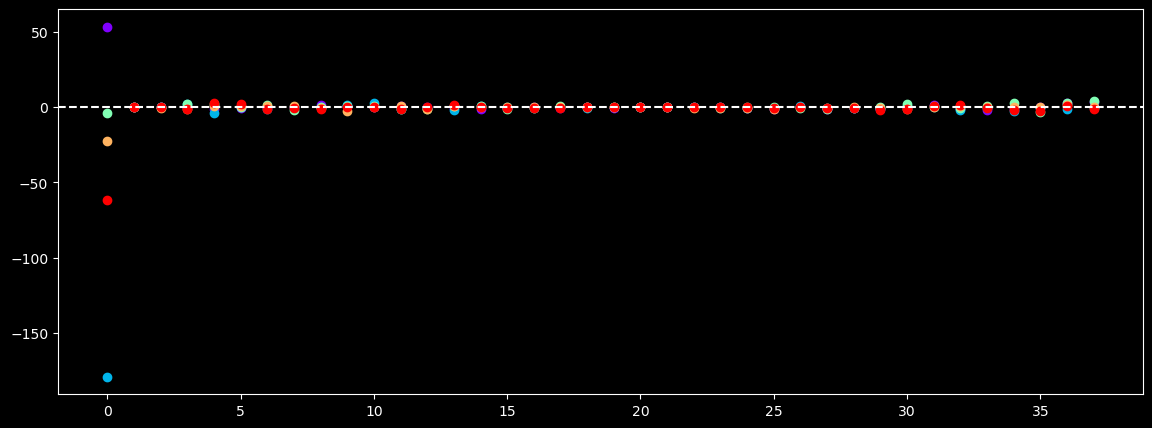

In [133]:
def obs_noise(true, unc, seed=42):
    global_random_state = np.random.RandomState(seed=seed)
    local_random_states = global_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=local_random_states[idx])
        idx+=1

    return noisy_obs

seeds = [1, 2, 3, 4, 5]
color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
fig, ax = plt.subplots(figsize=(14,5))
for seed in seeds:
    c = next(color)
    observed_vals=obs_noise(hare_true.values[0],obs_unc, seed=seed)
    plt.scatter(np.arange(0, len(observed_vals),1), observed_vals-hare_true.values[0], color=c)

plt.axhline(0, linestyle='--')

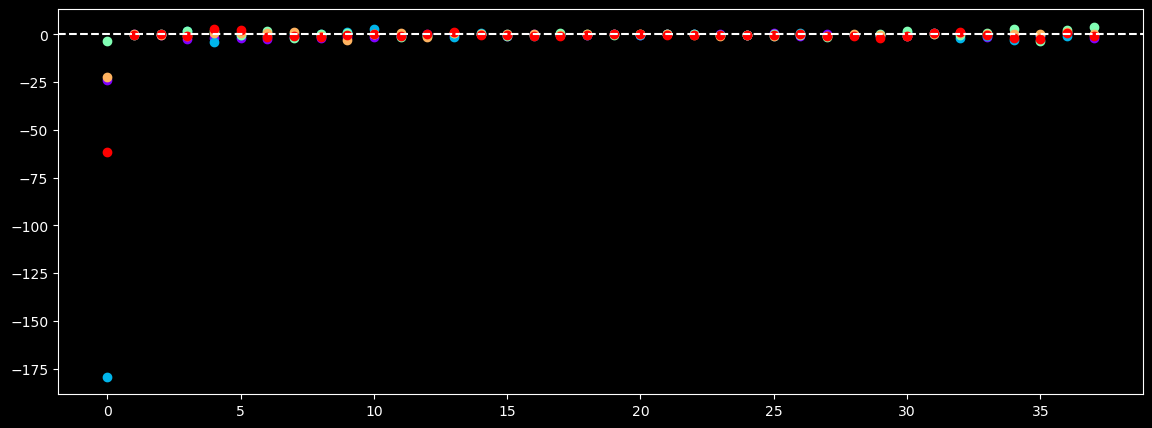

In [140]:
def obs_noise(true, unc, seed=42):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs

seeds = [1, 2, 3, 4, 5]
color = iter(cm.rainbow(np.linspace(0, 1, len(seeds))))
fig, ax = plt.subplots(figsize=(14,5))
for seed in seeds:
    c = next(color)
    observed_vals=obs_noise(hare_true.values[0],obs_unc, seed=seed)
    plt.scatter(np.arange(0, len(observed_vals),1), observed_vals-hare_true.values[0], color=c)

plt.axhline(0, linestyle='--')

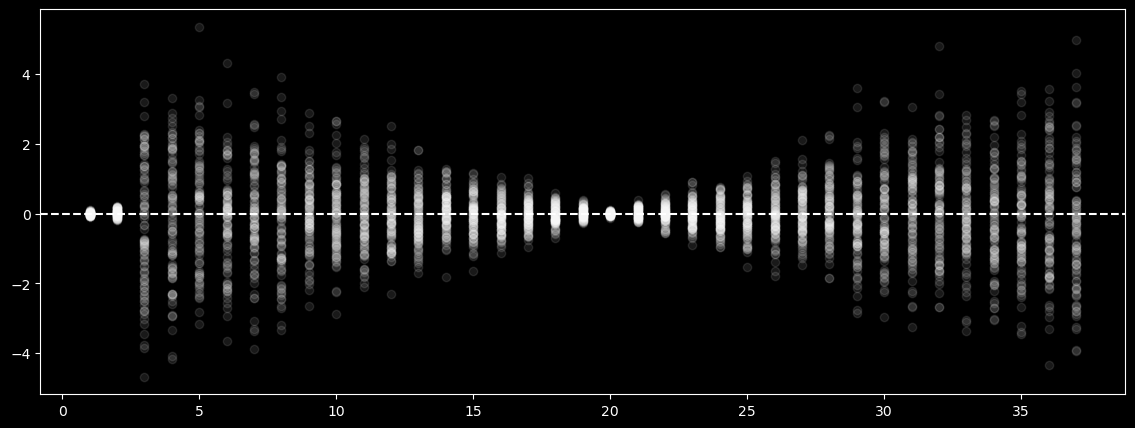

In [149]:
def obs_noise(true, unc, seed=42):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs

seeds = np.arange(0,100,1)
fig, ax = plt.subplots(figsize=(14,5))
for seed in seeds:
    observed_vals=obs_noise(hare_true.values[0],obs_unc, seed=seed)
    plt.scatter(np.arange(1, len(observed_vals),1), (observed_vals-hare_true.values[0])[1:], c='white', alpha=0.1)

plt.axhline(0, linestyle='--')

In [137]:
obs_noise(hare_true.values[0],obs_unc, seed=2)

array([ 5.46775242e+03,  8.89207703e-01, -3.48617106e-02,  9.81973473e+02,
        1.12255016e+03,  1.27363624e+03,  1.41738512e+03,  1.56097445e+03,
        1.69990721e+03,  1.83721126e+03,  1.97532467e+03,  2.10848236e+03,
        2.24519993e+03,  2.37978518e+03,  2.51655304e+03,  2.65190218e+03,
        2.78728262e+03,  2.92443863e+03,  3.06127733e+03,  3.19850733e+03,
        3.33570530e+03,  3.47354070e+03,  3.61160412e+03,  3.74971627e+03,
        3.88803206e+03,  4.02665638e+03,  4.16705752e+03,  4.30414665e+03,
        4.44332790e+03,  4.58137658e+03,  4.72155314e+03,  4.85727628e+03,
        4.98785255e+03,  5.12308050e+03,  5.25234536e+03,  5.38265699e+03,
        5.50734971e+03,  5.63294480e+03])

In [136]:
hare_true.values[0]

array([ 5.64697610e+03,  9.04566185e-01, -5.57996554e-02,  9.80082028e+02,
        1.12662696e+03,  1.27373361e+03,  1.41836579e+03,  1.56047718e+03,
        1.69956445e+03,  1.83591611e+03,  1.97267320e+03,  2.10940079e+03,
        2.24570981e+03,  2.38130085e+03,  2.51600184e+03,  2.65159776e+03,
        2.78789832e+03,  2.92446662e+03,  3.06147326e+03,  3.19835874e+03,
        3.33572663e+03,  3.47344367e+03,  3.61147901e+03,  3.74999080e+03,
        3.88844653e+03,  4.02723525e+03,  4.16609885e+03,  4.30482919e+03,
        4.44369914e+03,  4.58220684e+03,  4.72038373e+03,  4.85711724e+03,
        4.98945777e+03,  5.12366579e+03,  5.25505992e+03,  5.38316598e+03,
        5.50836512e+03,  5.63346647e+03])